<a href="https://colab.research.google.com/github/beeetea/ttareungi_visualization/blob/master/source_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
#from clustering import *
#from UI import *

In [0]:
# cluster.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster

# 데이터 필터링 함수
def data_filtering(set):
    filt = lambda x : (~(x["'대여대여소번호'"].isin(["'616'", "'623'", "'638'", "'639'"]) & x["'반납대여소번호'"].isin(["'616'", "'623'", "'638'", "'639'"])))
    set = set[filt]
    set = set.reset_index().drop('index',axis=1)
    set = set[set["'이용시간(분)'"]<60]

    return set

# 데이터 추출 함수(time(이용시간대), 이용시간 추출)
def data_extraction(set):
    time = pd.DataFrame(set["'대여일시'"].str.split('-').str[2].str[3:5].astype('float') + (1 / 60) * set["'대여일시'"].str.split('-').str[2].str[6:8].astype('float'))
    time.rename(columns={"'대여일시'": "'time'"}, inplace=True)
    uos = set.join(time)    

    return_set = uos[["'time'","'이용시간(분)'"]]
    return_set = return_set.reset_index().drop('index', axis=1)

    return return_set

# Elbow 기법을 적용하여 적합한 k를 구하기 위한 그래프를 그리는 함수
def SSE(dataSet):
    sse = []
    for i in range(20, 30):
        kmeans = cluster.KMeans(n_clusters=i, n_init=200)
        kmeans.fit(dataSet)
        sse.append(kmeans.inertia_)
   
    plt.plot(range(20, 30), sse, marker='o')
    plt.xlabel('클러스터 개수')
    plt.ylabel('SSE')
    plt.show()

# K-means 클러스터링을 수행하는 단계
def clustering(kClusters,set):
    results_set = []
    
    kmeans = cluster.KMeans(n_clusters=kClusters, n_init=200)
    
    kmeans.fit(set)
    
    results_set.append(list(kmeans.labels_))
    
    set["'K-means'"]=list(kmeans.labels_)
    set_centers=np.array(kmeans.cluster_centers_)
    print(set_centers)
    
    g = sns.pairplot(x_vars=["'time'"], y_vars=["'이용시간(분)'"], data=set, hue="'K-means'")
    plt.scatter(set_centers[:, 0], set_centers[:, 1], marker="x", color='r')
    g.fig.set_figheight(15)
    g.fig.set_figwidth(40)
    plt.show()
    
    return set_centers


In [0]:
# UI.py
import folium as fl
import random
import pandas as pd
import math

# 원하는 시간 내에 있는 클러스터의 번호를 추출하는 함수
def cluster_label(set_centers,kClusters,start_time,end_time):
    result_cluster_label=[]
    for i in range(kClusters):
        if(set_centers[i][0] >= start_time and set_centers[i][0] <= end_time):
            result_cluster_label.append(int(round(set_centers[i][2])))

    return result_cluster_label

# 대여소 ID를 추출하는 함수
def find_data(index,set,station_set,option):
    s = set.to_numpy()
    station = station_set.to_numpy()
    station_number=[]

    for i in range(set.shape[0]):
        if s[i][2]==index :
            station_number.append(station[i][option])

    return station_number

# Folium 맵에 사용할 색깔을 랜덤으로 지정하는 함수
def randColor():
    colorSet = ('green', 'blue', 'red', 'purple', 'orange')
    len_c = len(colorSet)
    selected_c = []
    while(1):
      tempColor = colorSet[random.randint(0, len_c-1)]
      if tempColor not in selected_c:
        selected_c.append(tempColor)
        return colorSet[random.randint(0, len_c-1)]
    
# Folium 맵을 작성하는 함수 
def map(set_centers,result_cluster_label,start_time,end_time,station_dict,station):
    uos_map=fl.Map(location = [37.5838657, 127.0587771],zoom_start=10)
    color_dict={}
    
    for i in set_centers:       
        if (i[0]> start_time and i[0] < end_time):
            color_dict[int(round(i[2]))] = randColor()
            fl.Circle(location=(37.5838657,127.0587771), radius=int(17.5*(10/36)*60*i[1]), color=color_dict[int(round(i[2]))]).add_to(uos_map)       
 
    for i in result_cluster_label:
      station_count = {}
      for value in station_dict[i]:
        if value not in station_count.keys():
          station_count[value] = 1
        else:
          station_count[value] += 1
      for loc in station_dict[i]:
        row = station[station["대여소ID"] == int(loc[1:-1])]["위도"]
        column = station[station["대여소ID"] == int(loc[1:-1])]["경도"]
        pop = station[station["대여소ID"] == int(loc[1:-1])]["대여소명"]
        loca=np.hstack([row,column])

        fl.CircleMarker(location = loca, radius=station_count[loc] ,popup=str(pop), color=color_dict[i], size = int(math.log((station_count[loc]+1), 4)),fill = True, fill_color=color_dict[i]).add_to(uos_map)

    return uos_map        


In [0]:
# 파일 업로드
t1 = pd.read_csv("/content/서울특별시 공공자전거 대여이력 정보_2018년_2분기_1.csv", encoding="CP949")
t2 = pd.read_csv("/content/서울특별시 공공자전거 대여이력 정보_2018년_2분기_2.csv", encoding="CP949")
t3 = pd.read_csv("/content/서울특별시 공공자전거 대여이력 정보_2018년_2분기_3.csv", encoding="CP949")
t4 = pd.read_csv("/content/서울특별시 공공자전거 대여이력 정보_2018년_2분기_4.csv", encoding="CP949")

df = pd.concat([t1, t2, t3, t4], axis=0)

In [0]:
from_uos = df[df["'대여대여소번호'"].isin(["'616'", "'623'", "'638'", "'639'"])] # 대여장소가 UOS인 df
to_uos = df[df["'반납대여소번호'"].isin(["'616'", "'623'", "'638'", "'639'"])] # 반납장소가 UOS인 df

from_uos = data_filtering(from_uos)
to_uos = data_filtering(to_uos)

In [0]:
from_uos.head(10)

,'자전거번호','대여일시','대여대여소번호','대여대여소명','대여거치대','반납일시','반납대여소번호','반납대여소명','반납거치대','이용시간(분)','이용거리(M)'
0,'SPB-08779','2018-04-01 00:11:50','623',' 서울시립대 정문 앞',1,'2018-04-01 00:26:50','628',' 휘봉고등학교 앞',13,13,2410
1,'SPB-12671','2018-04-01 00:31:44','639',' 서울시립대 후문',11,'2018-04-01 00:37:36','622',' 전농사거리 교통섬',15,5,1530
2,'SPB-15927','2018-04-01 00:40:13','638',' 서울시립대 정보기술관',17,'2018-04-01 01:15:57','622',' 전농사거리 교통섬',12,35,8850
3,'SPB-14935','2018-04-01 01:33:47','623',' 서울시립대 정문 앞',3,'2018-04-01 01:38:19','622',' 전농사거리 교통섬',12,4,810
4,'SPB-14077','2018-04-01 02:14:40','623',' 서울시립대 정문 앞',2,'2018-04-01 02:26:11','610',' 동대문중 교차로',6,11,1540
5,'SPB-02825','2018-04-01 02:57:23','616',' 서울시립대 앞',9,'2018-04-01 03:20:13','1327',' 상월곡역 3번출구',10,22,4980
6,'SPB-05217','2018-04-01 03:05:19','623',' 서울시립대 정문 앞',4,'2018-04-01 03:19:57','1449',' 상봉역 1번출구',9,14,3780
7,'SPB-11457','2018-04-01 03:17:32','623',' 서울시립대 정문 앞',17,'2018-04-01 03:22:37','624',' 전농동 동아아파트 앞',10,4,1310
8,'SPB-11467','2018-04-01 04:17:05','623',' 서울시립대 정문 앞',14,'2018-04-01 04:30:18','614',' 용두동 사거리',16,13,2790
9,'SPB-06064','2018-04-01 04:29:06','623',' 서울시립대 정문 앞',12,'2018-04-01 04:41:52','628',' 휘봉고등학교 앞',1,12,2550


In [0]:
from_set = data_extraction(from_uos)
to_set = data_extraction(to_uos)

In [0]:
#SSE(from_set)
#SSE(to_set)

[[ 1.71317829e+00  1.08914729e+01  1.60000000e+01]
 [ 1.77331615e+01  9.81443299e+00  1.40000000e+01]
 [ 1.03490667e+01  4.67040000e+01  1.80000000e+01]
 [ 1.63839793e+01  2.67906977e+01  2.00000000e+01]
 [ 1.32957389e+01  1.01941748e+01  3.00000000e+00]
 [ 1.91981293e+01  4.03979592e+01  6.00000000e+00]
 [ 2.12460409e+01  2.48927203e+01  1.00000000e+00]
 [ 1.60674648e+01  2.03661972e+01  1.20000000e+01]
 [ 1.72852608e+01  5.57755102e+01  1.50000000e+01]
 [ 1.95487678e+01  3.24280156e+01  1.10000000e+01]
 [ 1.23755886e+01  5.00371747e+00  2.30000000e+01]
 [ 1.85767677e+00  2.04242424e+01  8.00000000e+00]
 [ 1.43888889e+00  4.56296296e+00  9.00000000e+00]
 [ 1.76693085e+01  5.08158508e+00  5.00000000e+00]
 [ 2.14495050e+01  1.80000000e+01  2.10000000e+01]
 [ 1.09697183e+01  3.63521127e+01 -2.66453526e-14]
 [ 9.81610487e+00  1.53632959e+01  1.70000000e+01]
 [ 2.19821811e+01  1.12518519e+01  7.00000000e+00]
 [ 7.75101010e+00  7.62878788e+00  2.00000000e+00]
 [ 9.79333333e+00  2.53066667e+

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_

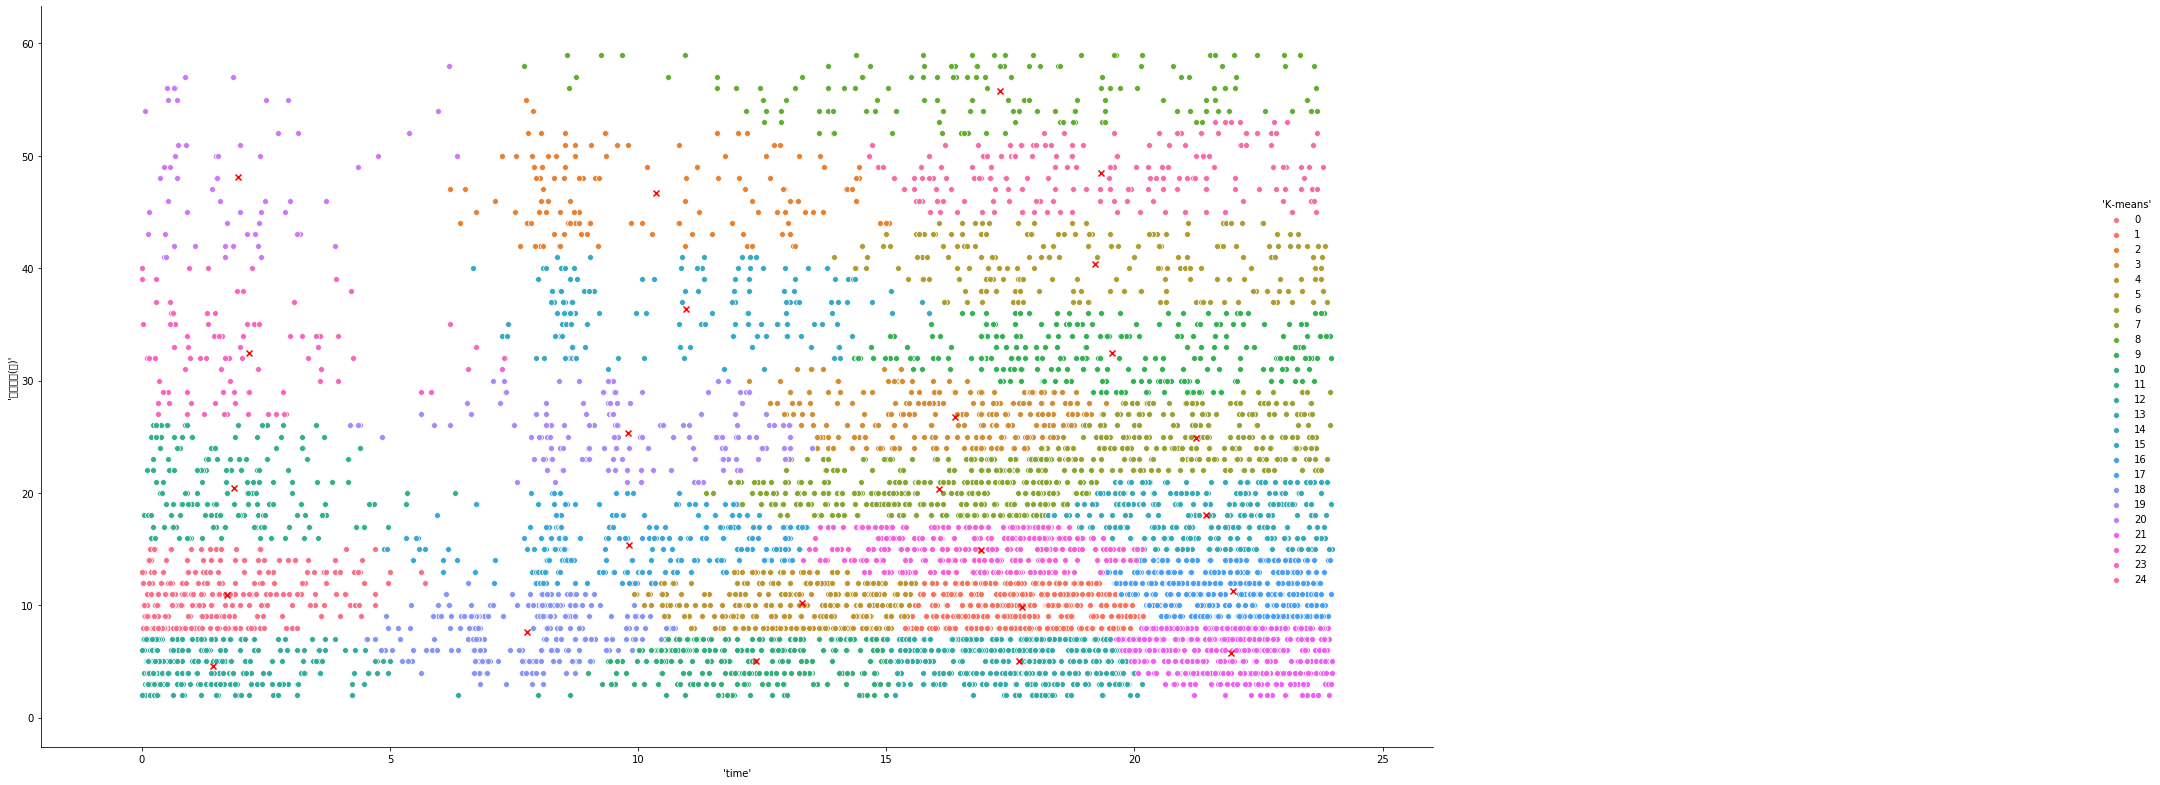

[[1.38497619e+01 2.66857143e+01 1.20000000e+01]
 [9.37687225e+00 1.68149780e+01 9.00000000e+00]
 [2.00906393e+01 5.48082192e+01 1.30000000e+01]
 [2.21303835e+01 6.89823009e+00 5.00000000e+00]
 [1.64705929e+01 1.22451923e+01 2.10000000e+01]
 [1.11744872e+01 5.46923077e+00 7.00000000e+00]
 [1.11578014e+00 2.22127660e+01 2.00000000e+01]
 [2.02228788e+01 3.73818182e+01 1.80000000e+01]
 [1.70581359e+01 6.56398104e+00 1.70000000e+01]
 [2.11166667e+01 1.72525253e+01 6.00000000e+00]
 [1.03293160e+01 1.04560261e+01 3.01980663e-14]
 [1.27282222e+01 4.40666667e+01 1.60000000e+01]
 [2.28941606e+00 6.56934307e+00 1.50000000e+01]
 [1.35592784e+01 3.45257732e+01 3.00000000e+00]
 [1.99384488e+01 4.86930693e+01 8.00000000e+00]
 [2.05304264e+01 2.38779070e+01 1.00000000e+01]
 [8.51306306e+00 2.44774775e+01 2.00000000e+00]
 [2.04422432e+01 3.08553459e+01 1.40000000e+01]
 [2.27812500e+00 3.17343750e+01 1.90000000e+01]
 [1.13714286e+01 5.46071429e+01 2.20000000e+01]
 [2.07994186e+01 4.33023256e+01 1.000000

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_

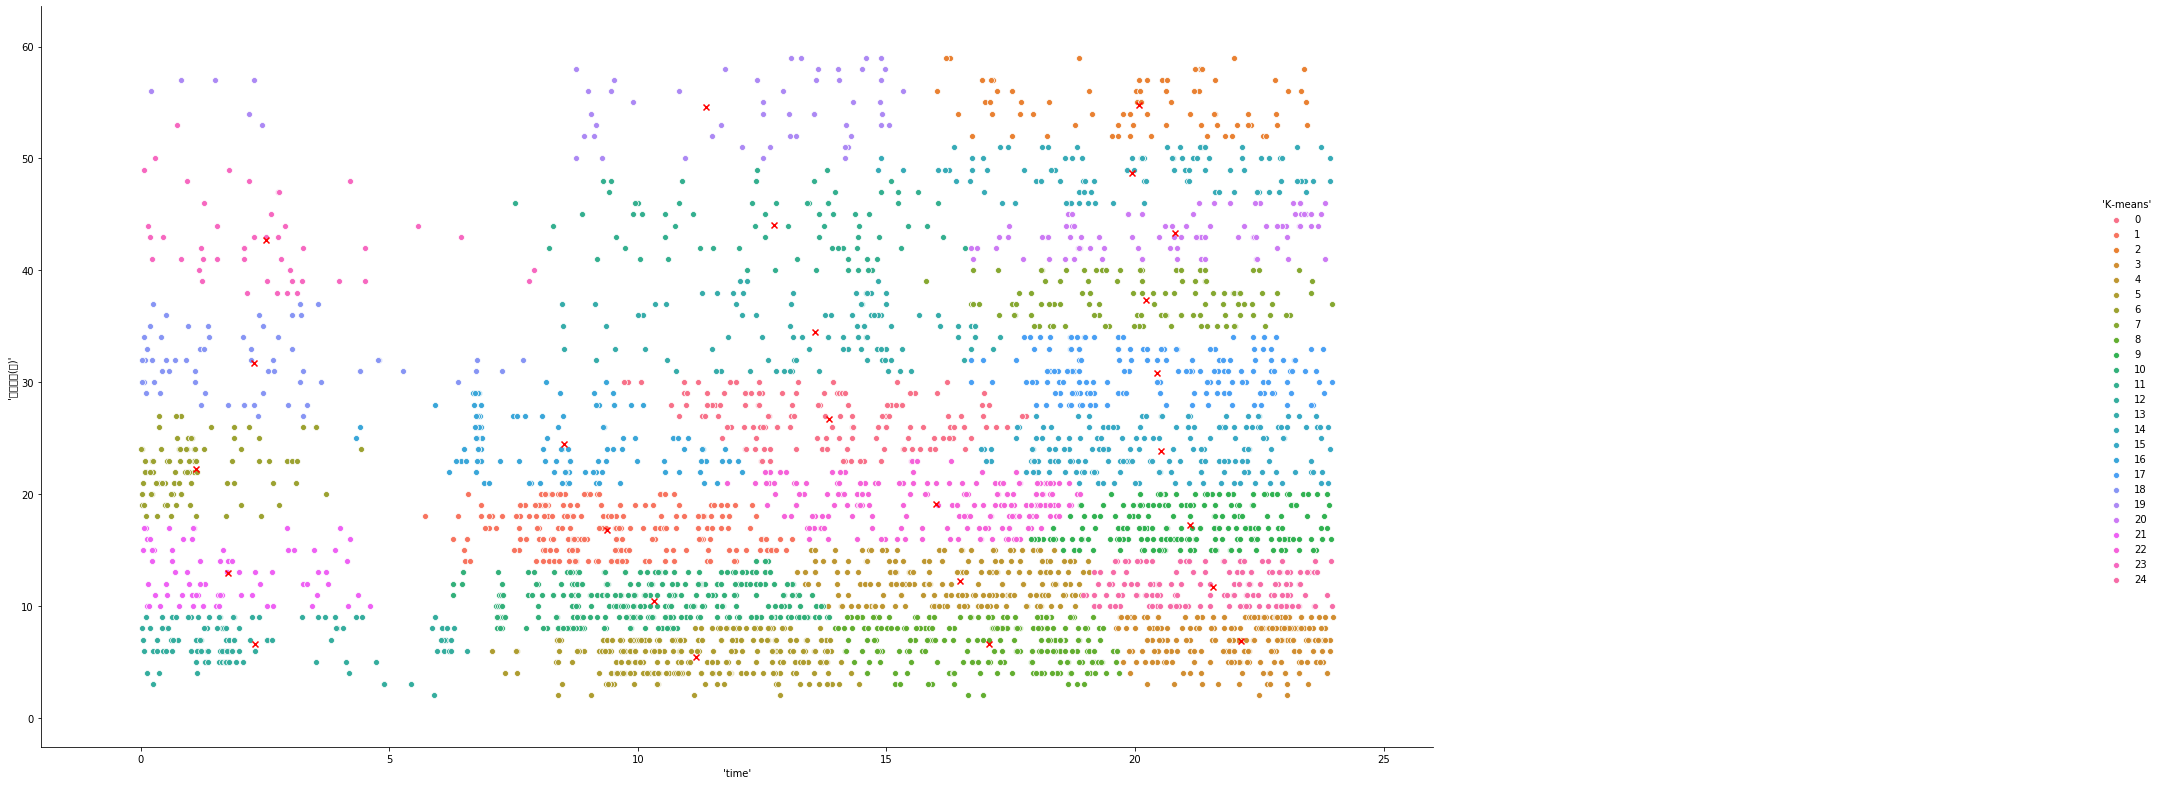

In [0]:
kClusters=25
from_set_centers = clustering(kClusters,from_set)
to_set_centers = clustering(kClusters,to_set)

In [0]:
from_time = [17,18]
to_time = [9,10.5]

from_result_cluster_label = cluster_label(from_set_centers,kClusters,from_time[0],from_time[1])
to_result_cluster_label = cluster_label(to_set_centers,kClusters,to_time[0],to_time[1])

In [0]:
to_result_cluster_label

[9, 0]

In [0]:
from_station_dict={}
to_station_dict={}

In [0]:
for i,data in enumerate(from_result_cluster_label):
    from_station_number = find_data(from_result_cluster_label[i],from_set,from_uos,6)
    from_station_dict[from_result_cluster_label[i]] = from_station_number

In [0]:
for i,data in enumerate(to_result_cluster_label):
    to_station_number = find_data(to_result_cluster_label[i],to_set,to_uos,2)
    to_station_dict[to_result_cluster_label[i]] = to_station_number

In [0]:
station = pd.read_csv('/content/station.csv', encoding="utf-8")

from_map = map(from_set_centers,from_result_cluster_label,from_time[0],from_time[1],from_station_dict,station)
to_map = map(to_set_centers,to_result_cluster_label,to_time[0],to_time[1],to_station_dict,station)

In [0]:
from_map

In [0]:
to_map